In [5]:
import gymnasium as gym
import numpy as np
import pickle
from tqdm.notebook import trange
import matplotlib.pyplot as plt
from IPython import display
import time

env = gym.make('Taxi-v3', render_mode='rgb_array')

# initializing q-table
action_space_size = env.action_space.n
state_space_size = env.observation_space.n

q_table = np.zeros((state_space_size, action_space_size))

# hyperparameters
MAX_STEPS_PER_EPISODE = 200

ALPHA = 0.4  # learning rate
GAMMA = 1  # discount rate

EPSILON = 1  # exploration rate
EPSILON_MAX = 1
EPSILON_MIN = 0.1
EPSILON_DECAY = (2 * EPSILON) / N_EPISODES

LOG_RATE = N_EPISODES / 10

In [9]:
def train(N_STEPS):

    action_space_size = env.action_space.n
    state_space_size = env.observation_space.n


    N_EPISODES = 1000

    ALPHA = 0.4  # learning rate
    GAMMA = 1  # discount rate

    EPSILON = 1  # exploration rate
    EPSILON_MAX = 1
    EPSILON_MIN = 0.1
    EPSILON_DECAY = (2 * EPSILON) / N_EPISODES
    ALPHAS = np.linspace(0, 1, 11)

    q_tables = {}

    def select_action(state):
        if np.random.rand() > EPSILON:
            return np.argmax(q_table[state, :])
        else:
            return env.action_space.sample()

    def state_value(state):
        return np.max(q_table[state, :])

    for ALPHA in ALPHAS:
        q_table = np.zeros((state_space_size, action_space_size))

        for episode in range(N_EPISODES):
            state, _ = env.reset()
            truncated = False

            action = select_action(state)
            states = [state]
            actions = [action]
            rewards = [0]

            tau = -N_STEPS + 1
            time_step = 0
            terminal_step = np.inf

            while tau < terminal_step:
                if time_step < terminal_step:
                    new_state, reward, done, _, info = env.step(action)

                    states.append(new_state)
                    rewards.append(reward)

                    truncated = (not done) and (time_step >= MAX_STEPS_PER_EPISODE)

                    if done or truncated:
                        terminal_step = time_step + 1
                    else:
                        action = select_action(new_state)
                        actions.append(action)
                        state = new_state

                if tau >= 0:
                    target = 0

                    if time_step + 1 >= terminal_step:
                        if truncated:
                            target = rewards[terminal_step] + \
                                GAMMA * state_value(terminal_step)
                        else:
                            target = rewards[terminal_step]
                    else:
                        target = rewards[time_step + 1] + \
                            GAMMA * state_value(states[time_step + 1])

                    for k in range(min(terminal_step - 1, time_step), tau, -1):
                        if actions[k] == np.argmax(q_table[states[k], :]):
                            target = rewards[k] + GAMMA * target
                        else:
                            target = rewards[k] + GAMMA * state_value(states[k])

                    q_table[states[tau], actions[tau]] += ALPHA * \
                        (target - q_table[states[tau], actions[tau]])

                time_step += 1
                tau += 1

            # updating epsilon
            EPSILON = max(EPSILON - EPSILON_DECAY, EPSILON_MIN)
        
        q_tables[ALPHA] = q_table
    
    return q_tables

In [10]:
def test(q_tables):
    ALPHAS = np.linspace(0, 1, 11)
    results = []
    N_EP = 10_000
    MAX_STEPS_PER_EPISODE = 200

    for ALPHA in ALPHAS:
        q_table = q_tables[ALPHA]
        sum_reward = 0
        for episode in range(N_EP):
            state, _ = env.reset()
            done = False

            for step in range(MAX_STEPS_PER_EPISODE):
                action = np.argmax(q_table[state, :])  # greedy action selection

                new_state, reward, done, truncated, info = env.step(action)
                sum_reward += reward

                state = new_state

                if done:
                    break
        results.append(sum_reward / N_EP)
    
    return results

1
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[-200.0, -105.6548, -13.3974, -24.7251, 1.7122, -4.7147, -13.7942, 4.8015, -1.8486, 2.578, 1.7569]
2
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[-200.0, -28.8491, 3.5518, 6.783, 5.6197, 6.9653, 3.7565, 2.8481, 6.376, 4.5262, 5.3812]
4
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[-200.0, 2.8816, 3.8253, 5.1458, 3.7245, -2.73, 3.4569, -16.9237, -7.1809, 3.3369, -95.7123]


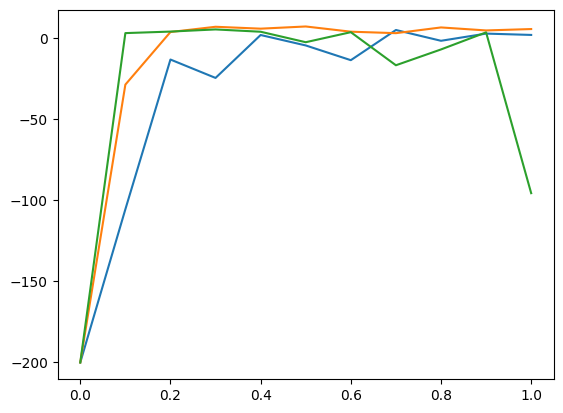

In [11]:
ALPHAS = np.linspace(0, 1, 11)

for n in [1,2,4]:
    q_tables = train(n)
    results = test(q_tables)
    plt.plot(ALPHAS, results)
    print(n)
    print(ALPHAS)
    print(results)

plt.show()